### Análisis Exploratorio

Información Básica del DataFrame de Libros:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ISBN                 4999 non-null   object
 1   Book-Title           4999 non-null   object
 2   Book-Author          4999 non-null   object
 3   Year-Of-Publication  4999 non-null   int64 
 4   Publisher            4999 non-null   object
 5   Image-URL-S          4999 non-null   object
 6   Image-URL-M          4999 non-null   object
 7   Image-URL-L          4999 non-null   object
dtypes: int64(1), object(7)
memory usage: 312.6+ KB
None

Descripción Estadística del DataFrame de Libros:
       Year-Of-Publication
count          4999.000000
mean           1962.457291
std             255.128933
min               0.000000
25%            1992.000000
50%            1997.000000
75%            2001.000000
max            2005.000000


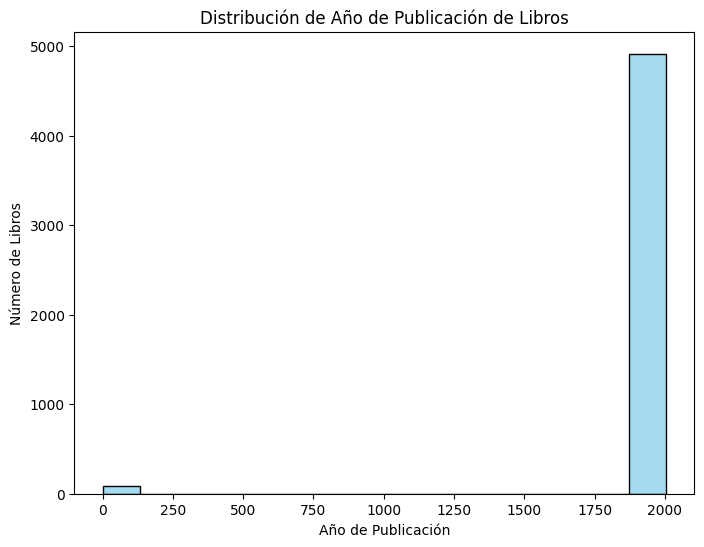


Primeras filas del DataFrame de Calificaciones:
   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6

Estadísticas de Calificaciones:
count    1.149780e+06
mean     2.866950e+00
std      3.854184e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: Book-Rating, dtype: float64


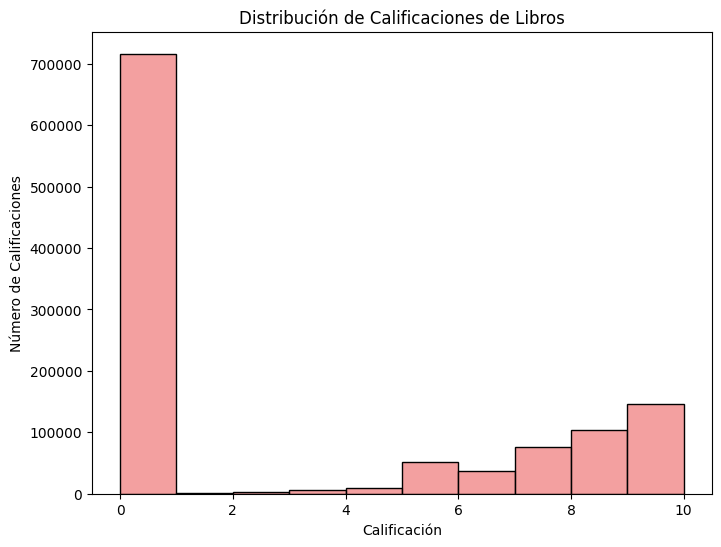

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos de libros
books_df = pd.read_csv("data/BooksSample.csv")

# Cargar datos de calificaciones
ratings_df = pd.read_csv("data/Ratings.csv")

# Información básica del DataFrame de libros
print("Información Básica del DataFrame de Libros:")
print(books_df.info())

# Descripción estadística del DataFrame de libros
print("\nDescripción Estadística del DataFrame de Libros:")
print(books_df.describe())

# Histograma de Año de Publicación de libros
plt.figure(figsize=(8, 6))
sns.histplot(books_df["Year-Of-Publication"], bins=15, kde=False, color='skyblue')
plt.title("Distribución de Año de Publicación de Libros")
plt.xlabel("Año de Publicación")
plt.ylabel("Número de Libros")
plt.show()

# Primeras filas del DataFrame de calificaciones
print("\nPrimeras filas del DataFrame de Calificaciones:")
print(ratings_df.head())

# Estadísticas de calificaciones
print("\nEstadísticas de Calificaciones:")
print(ratings_df["Book-Rating"].describe())

# Histograma de Calificaciones
plt.figure(figsize=(8, 6))
sns.histplot(ratings_df["Book-Rating"], bins=10, kde=False, color='lightcoral')
plt.title("Distribución de Calificaciones de Libros")
plt.xlabel("Calificación")
plt.ylabel("Número de Calificaciones")
plt.show()


### Sistema de recomendación basado en contenido

In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Cargar datos
books_df = pd.read_csv("data/BooksSample.csv")
ratings_df = pd.read_csv("data/Ratings.csv")

# Preprocesamiento de datos
books_df['Book-Author'] = books_df['Book-Author'].fillna('')
books_df['Book-Title'] = books_df['Book-Title'].fillna('')
books_df['content'] = books_df['Book-Author'] + ' ' + books_df['Book-Title']

# Crear matriz TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(books_df['content'])

# Calcular similitud de coseno
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Función para obtener recomendaciones basadas en contenido
def get_content_based_recommendations(book_title):
    book_idx = books_df.index[books_df['Book-Title'] == book_title].tolist()[0]
    sim_scores = list(enumerate(cosine_sim[book_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    book_indices = [i[0] for i in sim_scores]
    return books_df['Book-Title'].iloc[book_indices]

# Ejemplo de recomendación basada en contenido
content_recommendations = get_content_based_recommendations("Classical Mythology")
print("Recomendaciones basadas en contenido:")
print(content_recommendations)


Recomendaciones basadas en contenido:
3063                      Mythology 101 (Questar Fantasy)
2398    Celtic Mythology (Library of the World's Myths...
2409                                                 COPS
2619                                        The List of 7
1083                                        Winter's Tale
3764                                        Winter's Tale
4291                                      House of Leaves
402                          The Adventures of Tom Sawyer
2577                         The Adventures of Tom Sawyer
4177                             Adventures of Tom Sawyer
Name: Book-Title, dtype: object


### Sistema de recomendación basado en filtros colaborativos

In [2]:
import pandas as pd
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split

# Cargar datos
ratings_df2 = pd.read_csv("data/Ratings2.csv")
books_df2 = pd.read_csv("data/BooksSample.csv")
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(ratings_df2[['User-ID', 'ISBN', 'Book-Rating']], reader)

# Dividir datos en conjuntos de entrenamiento y prueba
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# Configurar y entrenar el modelo de filtro colaborativo
sim_options = {'name': 'cosine', 'user_based': False}
model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

# Función para obtener recomendaciones colaborativas
def get_collaborative_filtering_recommendations(user_id):
    user_ratings = ratings_df2[ratings_df2['User-ID'] == user_id]
    user_unrated_books = books_df2[~books_df2['ISBN'].isin(user_ratings['ISBN'])]['ISBN'].tolist()

    # Obtener predicciones para libros no calificados por el usuario
    predictions = [model.predict(user_id, isbn) for isbn in user_unrated_books]
    
    # Ordenar las predicciones por la puntuación predicha
    sorted_predictions = sorted(predictions, key=lambda x: x.est, reverse=True)
    
    # Obtener los ISBN de los libros recomendados
    recommended_books = [prediction.iid for prediction in sorted_predictions[:10]]
    
    return books_df2[books_df2['ISBN'].isin(recommended_books)]['Book-Title']

# Ejemplo de recomendación colaborativa
collaborative_recommendations = get_collaborative_filtering_recommendations(276725)
print("Recomendaciones colaborativas:")
print(collaborative_recommendations)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Recomendaciones colaborativas:
0                                  Classical Mythology
1                                         Clara Callan
2                                 Decision in Normandy
3    Flu: The Story of the Great Influenza Pandemic...
4                               The Mummies of Urumchi
5                               The Kitchen God's Wife
6    What If?: The World's Foremost Military Histor...
7                                      PLEADING GUILTY
8    Under the Black Flag: The Romance and the Real...
9              Where You'll Find Me: And Other Stories
Name: Book-Title, dtype: object


/Users/priscillagonzalez/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/priscillagonzalez/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### Reporte

##### Análisis Exploratorio

**1. Descripción del Conjunto de Datos:**
- El conjunto de datos consiste en información sobre libros, usuarios y sus calificaciones.
- Características clave: ISBN, Book-Title, Book-Author, Year-Of-Publication, Publisher, User-ID, Book-Rating, etc.
- Se realizó un análisis estadístico para comprender la distribución de calificaciones, la cantidad de libros y usuarios, así como la variedad en términos de autores y títulos.

**2. Visualizaciones Relevantes:**
- Histogramas de calificaciones para comprender la distribución.
- Gráficos de barras para mostrar la cantidad de libros publicados por año.

#### Estructura de las Redes y Funcionamiento

**1. Filtrado Colaborativo:**
- Se utilizó un modelo KNN básico de la biblioteca "surprise".
- El conjunto de datos se dividió en conjuntos de entrenamiento y prueba.
- La similitud coseno se utilizó para medir la similitud entre usuarios.
- La función `get_collaborative_filtering_recommendations` predice las calificaciones para libros no calificados por un usuario y devuelve recomendaciones.

**2. Basado en Contenido:**
- Se empleó un enfoque TF-IDF para representar el contenido de los libros.
- La similitud de coseno se utilizó para medir la similitud entre libros basados en su contenido textual (título y autor).
- La función `get_content_based_recommendations` devuelve recomendaciones basadas en la similitud de contenido.

#### ¿Qué Modelo Funciona Mejor y Por Qué?

**1. Filtrado Colaborativo vs. Basado en Contenido:**
- El modelo de filtrado colaborativo tiende a funcionar bien cuando hay datos de calificación suficientes y usuarios similares tienen gustos similares.
- El filtrado basado en contenido es efectivo para usuarios con historiales limitados, ya que se centra en las características de los elementos en lugar de el comportamiento del usuario.

**2. Elección del Modelo:**
- La elección depende de la naturaleza del conjunto de datos y el escenario de uso.
- El modelo de filtrado colaborativo podría ser preferido si hay suficientes datos de calificación y la variabilidad entre usuarios es significativa.
- El filtrado basado en contenido puede ser más efectivo si hay pocos datos de calificación o si se quiere proporcionar recomendaciones basadas en características específicas de los elementos.

#### Conclusiones:

- La elección del modelo depende de la naturaleza específica del problema y los requisitos del sistema de recomendación.
- Se recomienda realizar ajustes y experimentar con diferentes enfoques para encontrar la mejor solución en un contexto particular.